# Introduction to Accumulation Models: The Drift Diffusion Model (DDM)

**Lesson contents:**
1. What are accumulation models?
2. Introduction to the Drift Diffusion Model (DDM)
3. Generating synthetic data
4. Parameter recovery
5. Fitting real data

---

## Setup: Library Imports

In [1]:
# Import necessary libraries
# numpy: for numerical calculations and arrays
import numpy as np

# pandas: for organizing data in tables
import pandas as pd

# matplotlib: for creating plots and graphs
import matplotlib.pyplot as plt

# seaborn: for making plots look nicer
import seaborn as sns

# scipy.optimize: for finding best-fitting parameters
from scipy.optimize import minimize, differential_evolution

# scipy.stats: for statistical functions
from scipy import stats

# warnings: to hide warning messages
import warnings
warnings.filterwarnings('ignore')

# Make plots look nicer
sns.set_style('whitegrid')

# Set default plot size (width=12 inches, height=6 inches)
plt.rcParams['figure.figsize'] = (12, 6)

# Set default font size
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


---
## Part 1: What are Accumulation Models?

### The Basic Idea

When we make decisions, we don't decide instantly. Instead, we **accumulate evidence** over time until we have enough confidence to commit to a choice.

**Real-world example:**
Imagine you're deciding whether it's going to rain:
- You look at the sky: clouds are forming (+evidence for rain)
- You feel the temperature: it's warm (-evidence for rain)
- You see dark clouds approaching (+evidence for rain)
- You keep accumulating evidence until you're confident enough to decide

### Why Do We Need Models?

Accumulation models help us understand:
1. **How decisions are made** in the brain
2. **Why some decisions are faster** than others
3. **The trade-off between speed and accuracy**
4. **Individual differences** in decision-making

### Types of Accumulation Models

There are several models that describe evidence accumulation:

1. **Drift Diffusion Model (DDM)** ← We'll focus on this one today!
   - Single process accumulating evidence
   - Best for two-alternative forced choice tasks

2. **Linear Ballistic Accumulator (LBA)**
   - Multiple independent accumulators racing
   - Simpler mathematically

3. **Racing Diffusion Models**
   - Multiple diffusion processes racing
   - Can handle more than two choices

---

## Part 2: The Drift Diffusion Model (DDM) - Theory

### What is the DDM?

The **Drift Diffusion Model** describes how we make **binary decisions** (choosing between two options).

Think of it like this:
- You have two options: Option A (upper boundary) and Option B (lower boundary)
- You start somewhere in the middle
- Evidence pushes you towards one option or the other
- When you hit a boundary, you make that choice


### The Four Key Parameters

The DDM has 4 main parameters that control the decision process:

#### 1. **Drift Rate (v)** - Quality of Evidence
- Represents the **average rate** at which evidence accumulates
- High v = strong evidence, fast correct decisions
- Low v = weak evidence, slow decisions with more errors
- Can be positive (towards upper boundary) or negative (towards lower boundary)
- **Typical range:** -3 to +3
- **Example:** In a perceptual task, v is higher when the stimulus is clearer

#### 2. **Boundary Separation (a)** - Speed-Accuracy Trade-off
- The **distance between** the two decision boundaries
- High a = more cautious, slower but more accurate
- Low a = more impulsive, faster but more errors
- **Typical range:** 0.5 to 2.5
- **Example:** When a decision is important, we set higher boundaries (we want to be sure)

#### 3. **Starting Point (w)** - Initial Bias
- Where the accumulation process **starts**
- w = 0.5: no bias (exactly in the middle)
- w > 0.5: biased towards upper boundary
- w < 0.5: biased towards lower boundary
- **Range:** 0 to 1 (proportion of boundary separation)
- **Example:** If you expect rain, you start closer to the "rain" decision

#### 4. **Non-Decision Time (Ter)** - Other Processes
- Time for processes **not related to the decision** itself
- Includes:
  - Perceiving the stimulus (encoding)
  - Executing the motor response (pressing a button)
- **Typical range:** 0.2 to 0.5 seconds
- **Example:** The time it takes for your eyes to register what you see

### The Mathematical Process

The evidence accumulation is described by a **stochastic differential equation**:

$$dx = v \cdot dt + \sigma \cdot dW$$

Where:
- $x$ = accumulated evidence at time $t$
- $v$ = drift rate (systematic evidence accumulation)
- $\sigma$ = diffusion coefficient (noise), typically set to 1
- $dW$ = Wiener process increment (random noise)
- $dt$ = small time step

**In plain English:** At each moment, the evidence increases by:
1. A systematic amount (drift rate × time)
2. Plus some random noise (to simulate variability)

### What Does the DDM Predict?

The DDM makes predictions about **two things simultaneously**:

1. **Choice accuracy** (which boundary was reached)
2. **Response time** (how long it took to reach a boundary)

This is powerful because most models only predict one or the other!

### Neural Basis

The DDM is not just a mathematical model - it has **neural support**:
- Neurons in areas like **LIP (Lateral Intraparietal area)** show ramping activity during decisions
- The firing rate increases like evidence accumulation
- When a threshold is reached, a decision is made

---

## Part 3: Implementing the DDM

Now let's implement the mathematical functions that allow us to work with the DDM.

Don't worry if the math looks complex - we'll explain what each function does!

In [2]:
# Function 1: Calculate how many terms we need for the mathematical series
# This is a technical detail - just know it helps with accuracy
def utl_ks(t, w, prec):
    """
    Calculate the number of terms needed for the series.
    
    Parameters:
    - t: time
    - w: starting point parameter
    - prec: precision we want
    
    Returns:
    - K: number of terms to use
    """
    # Step 1: Calculate first estimate K1
    K1 = (np.sqrt(2 * t) - w) / 2
    
    # Step 2: Make a copy for K2
    K2 = np.copy(K1)
    
    # Step 3: Calculate precision threshold
    u_eps = np.minimum(-1, np.log(2 * np.pi * t**2 * prec**2))
    
    # Step 4: Calculate argument for K2
    sqrt_term = np.sqrt(-2 * u_eps - 2)
    arg = -t * (u_eps - sqrt_term)
    
    # Step 5: Update K2 where argument is positive
    positive_indices = arg > 0
    K2[positive_indices] = 0.5 * np.sqrt(arg[positive_indices]) - w / 2
    
    # Step 6: Take the maximum of K1 and K2, round up
    K_value = np.max([K1, K2])
    K = int(np.ceil(K_value))
    
    return K


# Function 2: Calculate the probability density for the Wiener process
# This tells us how likely a certain response time is
def utl_fsw(t, w, prec):
    """
    First passage time density for Wiener diffusion process.
    
    This calculates the probability of reaching a boundary at time t.
    
    Parameters:
    - t: time
    - w: starting point
    - prec: precision
    
    Returns:
    - f: probability density
    """
    # Step 1: Calculate how many terms we need
    K = utl_ks(t, w, prec)
    
    # Step 2: Create array to store result (same size as t)
    f = np.zeros_like(t)
    
    # Step 3: Check if K is valid
    K_is_positive = np.all(K > 0)
    K_is_finite = np.all(np.isfinite(K))
    
    if K_is_positive and K_is_finite:
        # Calculate the infinite series (but we stop at K terms)
        # We go from K down to 1
        for k in range(K, 0, -1):
            # Calculate first term
            exponent1 = -((w + 2 * k)**2) / (2 * t)
            term1 = (w + 2 * k) * np.exp(exponent1)
            
            # Calculate second term
            exponent2 = -((w - 2 * k)**2) / (2 * t)
            term2 = (w - 2 * k) * np.exp(exponent2)
            
            # Add both terms to f
            f = f + term1 + term2
        
        # Add the k=0 term
        exponent0 = -(w**2) / (2 * t)
        term0 = w * np.exp(exponent0)
        f = f + term0
        
        # Multiply by the constant factor
        constant = 1 / np.sqrt(2 * np.pi * t**3)
        f = constant * f
    
    return f


# Function 3: THE MAIN FUNCTION - Calculate DDM probability
# This is what we'll use most!
def utl_wfpt(t, v, a, w=0.5, prec=1e-4):
    """
    First passage time for the Wiener diffusion model.
    
    This is the MAIN function that calculates:
    "What is the probability of making a response at time t, 
     given the DDM parameters?"
    
    Parameters:
    - t: response time (in seconds)
    - v: drift rate
    - a: boundary separation
    - w: starting point bias (default 0.5 = no bias)
    - prec: precision (default is good enough)
    
    Returns:
    - p: probability density at time t
    """
    # Step 1: Calculate the exponential term
    exponent_part1 = -v * a * w
    exponent_part2 = -(v**2) * t / 2
    exponent = exponent_part1 + exponent_part2
    exp_term = np.exp(exponent)
    
    # Step 2: Calculate the boundary term
    boundary_term = 1 / (a**2)
    
    # Step 3: Multiply boundary term and exponential
    p = boundary_term * exp_term
    
    # Step 4: Get the first passage time density
    scaled_time = t / (a**2)
    fsw_value = utl_fsw(scaled_time, w, prec / p)
    
    # Step 5: Multiply to get final probability
    p = p * fsw_value
    
    return p


print("DDM functions implemented successfully!")
print("\nThe main function you need to know is: utl_wfpt")
print("It tells us the probability of a response at a given time.")

DDM functions implemented successfully!

The main function you need to know is: utl_wfpt
It tells us the probability of a response at a given time.


### Let's Visualize How Parameters Affect Response Times

Now we'll create some plots to understand how each parameter changes the predicted response times.

Creating visualization 1: Effect of drift rate...
Creating visualization 2: Effect of boundary separation...


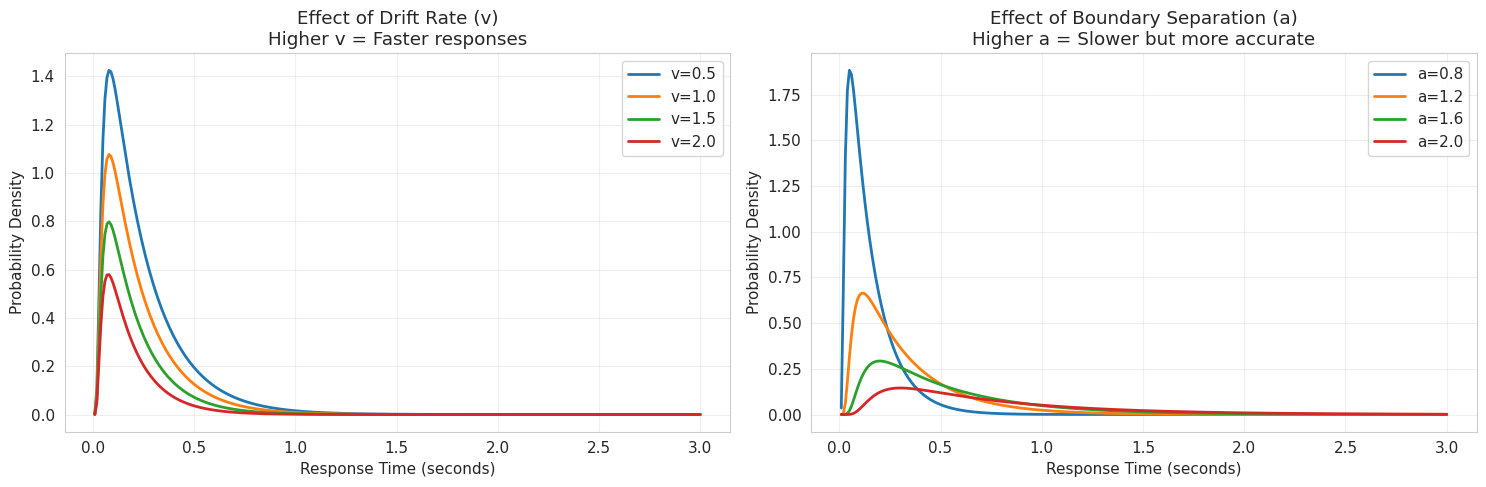


Key observations:
- Higher drift rate (v) → Faster and more peaked distributions
- Higher boundary (a) → Slower responses (distribution shifts right)


In [3]:
# Create a range of time values (from 0.01 to 3 seconds)
# linspace creates evenly spaced values
time_values = np.linspace(0.01, 3, 300)

# Create two plots side by side
# 1 row, 2 columns, size 15x5 inches
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Effect of drift rate (v)
print("Creating visualization 1: Effect of drift rate...")

# We'll test 4 different drift rates
drift_rates = [0.5, 1.0, 1.5, 2.0]

# Loop through each drift rate
for drift_rate in drift_rates:
    # Create empty list to store probabilities
    probabilities = []
    
    # Calculate probability for each time point
    for time in time_values:
        prob = utl_wfpt(time, v=drift_rate, a=1.0, w=0.5)
        probabilities.append(prob)
    
    # Convert list to numpy array for plotting
    probabilities = np.array(probabilities)
    
    # Plot the curve
    label_text = f'v={drift_rate}'
    axes[0].plot(time_values, probabilities, label=label_text, linewidth=2)

# Add labels and title to first plot
axes[0].set_xlabel('Response Time (seconds)')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Effect of Drift Rate (v)\nHigher v = Faster responses')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Effect of boundary separation (a)
print("Creating visualization 2: Effect of boundary separation...")

# We'll test 4 different boundary values
boundaries = [0.8, 1.2, 1.6, 2.0]

# Loop through each boundary value
for boundary in boundaries:
    # Create empty list to store probabilities
    probabilities = []
    
    # Calculate probability for each time point
    for time in time_values:
        prob = utl_wfpt(time, v=1.0, a=boundary, w=0.5)
        probabilities.append(prob)
    
    # Convert list to numpy array for plotting
    probabilities = np.array(probabilities)
    
    # Plot the curve
    label_text = f'a={boundary}'
    axes[1].plot(time_values, probabilities, label=label_text, linewidth=2)

# Add labels and title to second plot
axes[1].set_xlabel('Response Time (seconds)')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Effect of Boundary Separation (a)\nHigher a = Slower but more accurate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

print("\nKey observations:")
print("- Higher drift rate (v) → Faster and more peaked distributions")
print("- Higher boundary (a) → Slower responses (distribution shifts right)")

### Visualizing Stochastic Trajectories

Let's see how evidence accumulation actually works by simulating individual decision trials.

Each line shows one "trial" where evidence accumulates over time with noise.

Simulating Scenario 1: High drift rate...
Simulating Scenario 2: Low drift rate...
Simulating Scenario 3: High boundary...


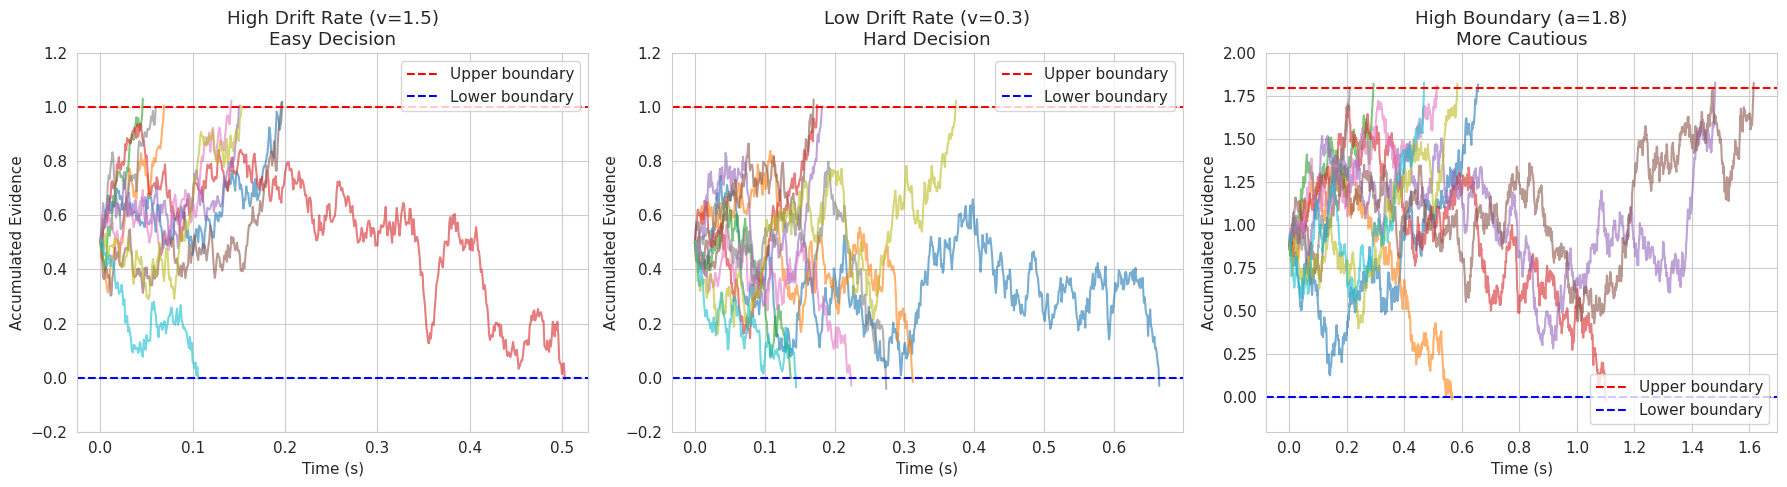


Scenario 1 (v=1.5): Mean RT = 0.162s, Accuracy = 80.00%
Scenario 2 (v=0.3): Mean RT = 0.266s, Accuracy = 40.00%
Scenario 3 (a=1.8): Mean RT = 0.749s, Accuracy = 80.00%


In [4]:
def simulate_ddm_trials(v, a, w=0.5, n_trials=10, dt=0.001, max_time=3.0):
    """
    Simulate DDM trials showing evidence accumulation trajectories.
    
    Parameters:
    - v: drift rate
    - a: boundary separation
    - w: starting point (proportion)
    - n_trials: number of trials to simulate
    - dt: time step
    - max_time: maximum time
    
    Returns:
    - trials: list of trajectories
    - rts: list of response times
    - responses: list of responses (1=upper, 0=lower)
    """
    # Create empty lists to store results
    trials = []
    rts = []
    responses = []
    
    # Simulate each trial
    for trial_num in range(n_trials):
        # Start at the bias position
        starting_position = w * a
        x = starting_position
        
        # Create list to store trajectory
        trajectory = []
        trajectory.append(x)
        
        # Initialize time
        t = 0
        
        # Keep accumulating evidence until we hit a boundary
        while True:
            # Calculate drift component (systematic)
            drift_component = v * dt
            
            # Calculate noise component (random)
            random_noise = np.random.randn()
            noise_component = np.sqrt(dt) * random_noise
            
            # Total change in evidence
            dx = drift_component + noise_component
            
            # Update position
            x = x + dx
            
            # Store position in trajectory
            trajectory.append(x)
            
            # Update time
            t = t + dt
            
            # Check if reached UPPER boundary
            if x >= a:
                rts.append(t)
                responses.append(1)
                break
            
            # Check if reached LOWER boundary
            elif x <= 0:
                rts.append(t)
                responses.append(0)
                break
            
            # Check for timeout
            elif t >= max_time:
                rts.append(np.nan)
                responses.append(np.nan)
                break
        
        # Add trajectory to list
        trials.append(trajectory)
    
    return trials, rts, responses

# Create three scenarios with different parameters
# Set up figure with 3 plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scenario 1: High drift rate (easy decision)
print("Simulating Scenario 1: High drift rate...")
trials1, rts1, resp1 = simulate_ddm_trials(v=1.5, a=1.0, w=0.5, n_trials=10)

# Plot each trial trajectory
for trial in trials1:
    # Create time array for this trial
    n_steps = len(trial)
    time_array = []
    for i in range(n_steps):
        time_array.append(i * 0.001)
    
    # Plot this trajectory
    axes[0].plot(time_array, trial, alpha=0.6, linewidth=1.5)

# Add boundary lines
axes[0].axhline(y=1.0, color='red', linestyle='--', label='Upper boundary')
axes[0].axhline(y=0, color='blue', linestyle='--', label='Lower boundary')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Accumulated Evidence')
axes[0].set_title('High Drift Rate (v=1.5)\nEasy Decision')
axes[0].legend()
axes[0].set_ylim(-0.2, 1.2)

# Scenario 2: Low drift rate (hard decision)
print("Simulating Scenario 2: Low drift rate...")
trials2, rts2, resp2 = simulate_ddm_trials(v=0.3, a=1.0, w=0.5, n_trials=10)

# Plot each trial trajectory
for trial in trials2:
    # Create time array for this trial
    n_steps = len(trial)
    time_array = []
    for i in range(n_steps):
        time_array.append(i * 0.001)
    
    # Plot this trajectory
    axes[1].plot(time_array, trial, alpha=0.6, linewidth=1.5)

# Add boundary lines
axes[1].axhline(y=1.0, color='red', linestyle='--', label='Upper boundary')
axes[1].axhline(y=0, color='blue', linestyle='--', label='Lower boundary')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Accumulated Evidence')
axes[1].set_title('Low Drift Rate (v=0.3)\nHard Decision')
axes[1].legend()
axes[1].set_ylim(-0.2, 1.2)

# Scenario 3: High boundary (more cautious)
print("Simulating Scenario 3: High boundary...")
trials3, rts3, resp3 = simulate_ddm_trials(v=1.0, a=1.8, w=0.5, n_trials=10)

# Plot each trial trajectory
for trial in trials3:
    # Create time array for this trial
    n_steps = len(trial)
    time_array = []
    for i in range(n_steps):
        time_array.append(i * 0.001)
    
    # Plot this trajectory
    axes[2].plot(time_array, trial, alpha=0.6, linewidth=1.5)

# Add boundary lines
axes[2].axhline(y=1.8, color='red', linestyle='--', label='Upper boundary')
axes[2].axhline(y=0, color='blue', linestyle='--', label='Lower boundary')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Accumulated Evidence')
axes[2].set_title('High Boundary (a=1.8)\nMore Cautious')
axes[2].legend()
axes[2].set_ylim(-0.2, 2.0)

# Adjust spacing and show
plt.tight_layout()
plt.show()

# Calculate and display statistics
# Convert responses to arrays and remove NaN values
resp1_clean = [r for r in resp1 if not np.isnan(r)]
resp2_clean = [r for r in resp2 if not np.isnan(r)]
resp3_clean = [r for r in resp3 if not np.isnan(r)]

rts1_clean = [rt for rt in rts1 if not np.isnan(rt)]
rts2_clean = [rt for rt in rts2 if not np.isnan(rt)]
rts3_clean = [rt for rt in rts3 if not np.isnan(rt)]

# Calculate means
mean_rt1 = np.mean(rts1_clean)
mean_rt2 = np.mean(rts2_clean)
mean_rt3 = np.mean(rts3_clean)

accuracy1 = np.mean(resp1_clean)
accuracy2 = np.mean(resp2_clean)
accuracy3 = np.mean(resp3_clean)

print(f"\nScenario 1 (v=1.5): Mean RT = {mean_rt1:.3f}s, Accuracy = {accuracy1:.2%}")
print(f"Scenario 2 (v=0.3): Mean RT = {mean_rt2:.3f}s, Accuracy = {accuracy2:.2%}")
print(f"Scenario 3 (a=1.8): Mean RT = {mean_rt3:.3f}s, Accuracy = {accuracy3:.2%}")

---
## Part 4: Generating Synthetic Data

Before we work with real data, let's generate **synthetic data** (fake data where we know the true parameters).

This is important because:
1. We can test if our methods work
2. We know what the "true" answer should be
3. We can learn what good data looks like

### The Simulation Method

We'll use a proper method that generates realistic data by:
1. Calculating the probability of each possible response time
2. Randomly sampling from this probability distribution
3. Recording both the response time and which choice was made

In [5]:
# Set the true parameters (these are what we'll try to recover later)
true_v = 1.2      # Drift rate: strength of evidence
true_a = 1.5      # Boundary separation: speed-accuracy trade-off
true_w = 0.5      # Starting point: no bias (exactly in the middle)
true_ter = 0.35   # Non-decision time: perceptual and motor processes

# Number of trials to simulate
n_trials = 1000  # More trials = better parameter recovery

print("Generating synthetic data...")
print(f"True parameters: v={true_v}, a={true_a}, w={true_w}, Ter={true_ter}")
print(f"Number of trials: {n_trials}")

# Create arrays to store results
# np.zeros creates an array filled with zeros
rt = np.zeros(n_trials)    # Response times
resp = np.zeros(n_trials)  # Responses (0 or 1)

# Time axis for probability calculation
# arange creates values from 0.001 to 3, stepping by 0.001
time_axis = np.arange(0.001, 3, 0.001)

# Generate each trial
print("\nGenerating trials...")
for n in range(n_trials):
    # Show progress every 100 trials
    if (n + 1) % 100 == 0:
        print(f"  Generated {n + 1}/{n_trials} trials...")
    
    # Step 1: Calculate probability densities for both boundaries
    # For LOWER boundary: use -v and (1-w)
    P1 = utl_wfpt(time_axis, -true_v, true_a, 1 - true_w)
    
    # For UPPER boundary: use +v and w  
    P2 = utl_wfpt(time_axis, true_v, true_a, true_w)
    
    # Step 2: Combine probabilities
    # P2 goes with NEGATIVE times
    P2_reversed = P2[::-1]  # Reverse the array
    
    # P1 goes with POSITIVE times
    P = np.concatenate([P2_reversed, P1])
    
    # Create corresponding time values
    negative_times = -time_axis[::-1]  # Negative times, reversed
    positive_times = time_axis         # Positive times
    time_values = np.concatenate([negative_times, positive_times])
    
    # Step 3: Normalize probabilities (make sure they sum to 1)
    P_sum = np.sum(P)
    P = P / P_sum
    
    # Step 4: Sample a time from the probability distribution
    selected_time = np.random.choice(time_values, p=P)
    
    # Step 5: Determine response and RT based on sign of time
    # POSITIVE time → P1 was used → response = 1
    # NEGATIVE time → P2 was used → response = 0
    if selected_time > 0:
        rt[n] = selected_time  # Already positive
        resp[n] = 1
    else:
        rt[n] = -selected_time  # Make it positive
        resp[n] = 0

# Step 6: Add non-decision time to all RTs
print("\nAdding non-decision time...")
for i in range(n_trials):
    rt[i] = rt[i] + true_ter

# Step 7: Create DataFrame to organize data
print("Creating data table...")
synthetic_data = pd.DataFrame({
    'rt': rt,
    'response': resp
})

# Calculate statistics
total_trials = len(synthetic_data)
upper_count = int(np.sum(resp == 1))
lower_count = int(np.sum(resp == 0))
upper_percent = np.mean(resp) * 100
lower_percent = (1 - np.mean(resp)) * 100
mean_rt = synthetic_data['rt'].mean()

print(f"\nData generation complete!")
print(f"Total trials: {total_trials}")
print(f"Upper boundary (resp=1): {upper_count} trials ({upper_percent:.1f}%)")
print(f"Lower boundary (resp=0): {lower_count} trials ({lower_percent:.1f}%)")
print(f"Mean RT: {mean_rt:.3f} seconds")
print("\nFirst 5 trials:")
print(synthetic_data.head())

Generating synthetic data...
True parameters: v=1.2, a=1.5, w=0.5, Ter=0.35
Number of trials: 1000

Generating trials...
  Generated 100/1000 trials...
  Generated 200/1000 trials...
  Generated 300/1000 trials...
  Generated 400/1000 trials...
  Generated 500/1000 trials...
  Generated 600/1000 trials...
  Generated 700/1000 trials...
  Generated 800/1000 trials...
  Generated 900/1000 trials...
  Generated 1000/1000 trials...

Adding non-decision time...
Creating data table...

Data generation complete!
Total trials: 1000
Upper boundary (resp=1): 877 trials (87.7%)
Lower boundary (resp=0): 123 trials (12.3%)
Mean RT: 0.796 seconds

First 5 trials:
      rt  response
0  0.996       1.0
1  0.502       1.0
2  0.573       0.0
3  0.996       1.0
4  0.988       1.0


### Visualizing the Generated Data

Let's look at what our synthetic data looks like!

Creating Plot 1: Overall RT distribution...
Creating Plot 2: RTs by response type...
Creating Plot 3: Cumulative distribution...


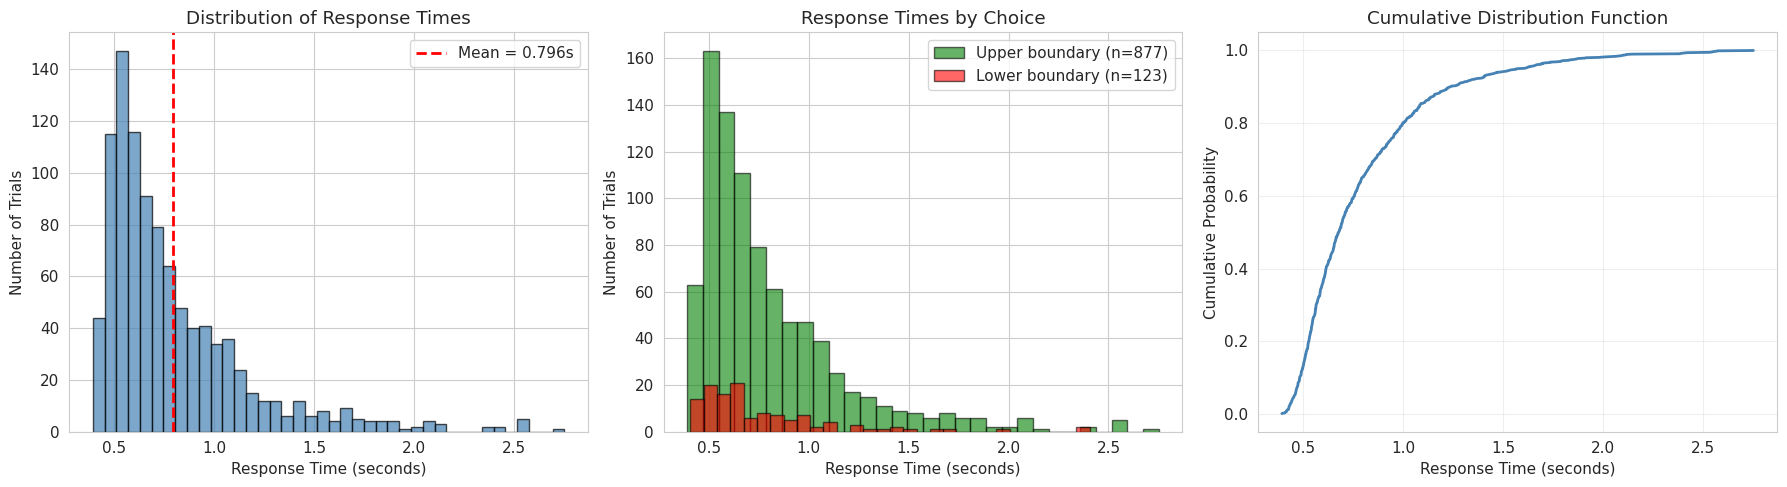


Data characteristics:
Fastest RT: 0.393s
Slowest RT: 2.752s
Median RT: 0.677s


In [6]:
# Create three plots to understand our data
# 1 row, 3 columns, size 18x5 inches
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Histogram of all response times
print("Creating Plot 1: Overall RT distribution...")

# Get the RT data
all_rts = synthetic_data['rt']

# Create histogram with 40 bins
axes[0].hist(all_rts, bins=40, edgecolor='black', alpha=0.7, color='steelblue')

# Calculate and plot mean RT
mean_rt = all_rts.mean()
axes[0].axvline(mean_rt, color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {mean_rt:.3f}s')

# Add labels
axes[0].set_xlabel('Response Time (seconds)')
axes[0].set_ylabel('Number of Trials')
axes[0].set_title('Distribution of Response Times')
axes[0].legend()

# Plot 2: Separate histograms for correct vs incorrect responses
print("Creating Plot 2: RTs by response type...")

# Response = 1 means upper boundary
# Response = 0 means lower boundary

# Filter data for each response type
correct_trials = synthetic_data[synthetic_data['response'] == 1]
incorrect_trials = synthetic_data[synthetic_data['response'] == 0]

# Get RTs for each response type
correct_rts = correct_trials['rt']
incorrect_rts = incorrect_trials['rt']

# Count trials
n_correct = len(correct_trials)
n_incorrect = len(incorrect_trials)

# Plot both histograms
axes[1].hist(correct_rts, bins=30, alpha=0.6, 
             label=f'Upper boundary (n={n_correct})', 
             edgecolor='black', color='green')
axes[1].hist(incorrect_rts, bins=30, alpha=0.6, 
             label=f'Lower boundary (n={n_incorrect})', 
             edgecolor='black', color='red')

# Add labels
axes[1].set_xlabel('Response Time (seconds)')
axes[1].set_ylabel('Number of Trials')
axes[1].set_title('Response Times by Choice')
axes[1].legend()

# Plot 3: Cumulative distribution
print("Creating Plot 3: Cumulative distribution...")

# This shows the proportion of responses that occurred by each time
# Step 1: Sort all RTs from smallest to largest
sorted_rts = np.sort(all_rts)

# Step 2: Create cumulative probability
# Each point represents how many trials happened up to that time
n_total = len(sorted_rts)
cumulative_prob = []
for i in range(n_total):
    cum_prob = (i + 1) / n_total
    cumulative_prob.append(cum_prob)

# Convert to array
cumulative_prob = np.array(cumulative_prob)

# Plot cumulative distribution
axes[2].plot(sorted_rts, cumulative_prob, linewidth=2, color='steelblue')

# Add labels
axes[2].set_xlabel('Response Time (seconds)')
axes[2].set_ylabel('Cumulative Probability')
axes[2].set_title('Cumulative Distribution Function')
axes[2].grid(True, alpha=0.3)

# Adjust spacing between plots
plt.tight_layout()

# Show all plots
plt.show()

# Print data characteristics
print("\nData characteristics:")
print(f"Fastest RT: {all_rts.min():.3f}s")
print(f"Slowest RT: {all_rts.max():.3f}s")
print(f"Median RT: {all_rts.median():.3f}s")

---
## Part 5: Parameter Recovery

### What is Parameter Recovery?

**Parameter recovery** is a crucial validation step:

1. We **generated data** with known parameters (v=1.2, a=1.5, Ter=0.35)
2. Now we'll **pretend we don't know** these parameters
3. We'll use an algorithm to **estimate** the parameters from the data
4. We'll **compare** the estimated parameters to the true ones

**Why is this important?**
- It tells us if our fitting method works correctly
- If we can't recover known parameters, we can't trust estimates from real data!

### How Parameter Fitting Works

We use **Maximum Likelihood Estimation**:
1. We try different parameter values
2. For each set of parameters, we calculate: "How likely is our observed data?"
3. We choose the parameters that make our data most likely

### Implementing the Fitting Function

In [7]:
def calculate_likelihood(parameters, rt_data, response_data):
    """
    Calculate negative log-likelihood.
    
    IMPORTANT: Must match the simulation method!
    - response=1 uses P1 (with -v and 1-w) 
    - response=0 uses P2 (with +v and w)
    
    Parameters:
    - parameters: array with [v, a, ter]
    - rt_data: array of response times
    - response_data: array of responses (0 or 1)
    
    Returns:
    - nll: negative log-likelihood (lower is better)
    """
    # Step 1: Extract parameters from array
    v = abs(parameters[0])    # Drift rate (take absolute value)
    a = parameters[1]          # Boundary separation
    ter = parameters[2]        # Non-decision time
    w = 0.5                    # Starting point (fixed at 0.5)
    
    # Step 2: Check if parameters are valid
    # If not valid, return a very large number (bad fit)
    if a <= 0.1:               # Boundary too small
        return 1e10
    if a > 3.0:                # Boundary too large
        return 1e10
    if ter < 0.05:             # Non-decision time too small
        return 1e10
    if ter > 1.0:              # Non-decision time too large
        return 1e10
    if v > 5:                  # Drift rate too large
        return 1e10
    if v < 0.01:               # Drift rate too small
        return 1e10
    
    # Step 3: Initialize negative log-likelihood
    nll = 0
    
    # Step 4: Loop through each trial
    n_trials = len(rt_data)
    for i in range(n_trials):
        # Get RT for this trial
        rt_i = rt_data[i]
        
        # Subtract non-decision time to get decision time
        dt = rt_i - ter
        
        # Check if decision time is valid
        if dt <= 0.001:
            # Too short - add penalty
            nll = nll + 10
            continue  # Skip to next trial
        
        # Try to calculate probability
        try:
            # Get response for this trial
            response_i = response_data[i]
            
            # Calculate probability MATCHING the simulation!
            if response_i == 1:
                # response=1 was generated with P1: -v and (1-w)
                prob = utl_wfpt(dt, v=-v, a=a, w=1-w)
            else:
                # response=0 was generated with P2: +v and w
                prob = utl_wfpt(dt, v=v, a=a, w=w)
            
            # Check if probability is valid
            if prob > 1e-10:
                # Add negative log probability
                nll = nll - np.log(prob)
            else:
                # Probability too small - add penalty
                nll = nll + 10
        
        except:
            # If there's an error, add penalty
            nll = nll + 10
    
    return nll


def fit_ddm_model(data):
    """
    Fit DDM with multiple starting points.
    
    Parameters:
    - data: DataFrame with 'rt' and 'response' columns
    
    Returns:
    - best_result: optimization result with best parameters
    """
    # Step 1: Extract data from DataFrame
    rt_data = data['rt'].values
    response_data = data['response'].values
    
    # Step 2: Check if responses need to be flipped
    # (if accuracy is below 50%, flip responses)
    accuracy = response_data.mean()
    if accuracy < 0.5:
        print("Flipping responses (accuracy was below 50%)")
        response_data = 1 - response_data
    
    print("Starting optimization (Nelder-Mead with multiple starts)...")
    
    # Step 3: Initialize variables to track best result
    best_result = None
    best_nll = np.inf  # Infinity (very large number)
    
    # Step 4: Try multiple starting points
    # Format: [v, a, ter]
    starting_points = [
        [1.0, 1.2, 0.3],
        [0.5, 1.5, 0.25],
        [1.5, 1.0, 0.35],
        [2.0, 1.8, 0.4]
    ]
    
    # Try each starting point
    n_starts = len(starting_points)
    for start_idx in range(n_starts):
        start = starting_points[start_idx]
        print(f"  Trying starting point {start_idx + 1}/{n_starts}: v={start[0]}, a={start[1]}, ter={start[2]}")
        
        # Run optimization
        result = minimize(
            calculate_likelihood,           # Function to minimize
            start,                          # Starting parameters
            args=(rt_data, response_data),  # Additional arguments
            method='Nelder-Mead',           # Optimization method
            options={
                'maxiter': 5000,            # Maximum iterations
                'xatol': 1e-4,              # Tolerance for parameters
                'fatol': 1e-4               # Tolerance for function value
            }
        )
        
        # Check if this is the best result so far
        if result.fun < best_nll:
            best_nll = result.fun
            best_result = result
            print(f"    New best! NLL = {best_nll:.2f}")
        else:
            print(f"    NLL = {result.fun:.2f}")
    
    print("\nOptimization complete!")
    print(f"Best negative log-likelihood: {best_nll:.2f}")
    
    return best_result


print("Fitting functions defined!")
print("Ready to fit the model to data.")

Fitting functions defined!
Ready to fit the model to data.


### Now Let's Actually Fit the Model!

In [8]:
print("="*60)
print("PARAMETER RECOVERY TEST")
print("="*60)

# Fit the model to our synthetic data
print("\nFitting model to synthetic data...\n")
fit_result = fit_ddm_model(synthetic_data)

# Extract recovered parameters from the result
recovered_v = abs(fit_result.x[0])    # Drift rate (take absolute value)
recovered_a = fit_result.x[1]          # Boundary separation
recovered_ter = fit_result.x[2]        # Non-decision time

print("\n" + "="*60)
print("COMPARISON: TRUE vs RECOVERED PARAMETERS")
print("="*60)
print(f"{'Parameter':<20} {'True Value':<15} {'Recovered':<15} {'Error':<10}")
print("-"*60)

# Calculate errors for each parameter
# Error = absolute difference between true and recovered
error_v = abs(abs(true_v) - recovered_v)      # Compare absolute values
error_a = abs(true_a - recovered_a)
error_ter = abs(true_ter - recovered_ter)

# Print comparison table
print(f"{'Drift rate (|v|)':<20} {abs(true_v):<15.3f} {recovered_v:<15.3f} {error_v:<10.3f}")
print(f"{'Boundary (a)':<20} {true_a:<15.3f} {recovered_a:<15.3f} {error_a:<10.3f}")
print(f"{'Non-decision (Ter)':<20} {true_ter:<15.3f} {recovered_ter:<15.3f} {error_ter:<10.3f}")

print("\n" + "="*60)
print(f"Optimization successful: {fit_result.success}")
print(f"Negative log-likelihood: {fit_result.fun:.2f}")

# Calculate mean absolute error across all parameters
all_errors = [error_v, error_a, error_ter]
mean_error = np.mean(all_errors)
print(f"Mean absolute error: {mean_error:.4f}")

# Evaluate recovery quality based on mean error
print("\nRECOVERY QUALITY:")
if mean_error < 0.1:
    print("✓ EXCELLENT recovery!")
    print("  The recovered parameters are very close to the true values.")
elif mean_error < 0.2:
    print("✓ GOOD recovery")
    print("  The recovered parameters are reasonably close to the true values.")
else:
    print("⚠ MODERATE recovery - may need more trials or better optimization")
    print("  There is noticeable error in parameter recovery.")
    print("  Consider: 1) Collecting more trials, or 2) Adjusting optimization settings")
    
print("\n" + "="*60)
print("NOTE: Drift rate sign is arbitrary in this model.")
print("We only recover |v| because v and -v are equivalent")
print("if we swap which response is coded as 0 vs 1.")
print("="*60)

PARAMETER RECOVERY TEST

Fitting model to synthetic data...

Starting optimization (Nelder-Mead with multiple starts)...
  Trying starting point 1/4: v=1.0, a=1.2, ter=0.3
    New best! NLL = 402.84
  Trying starting point 2/4: v=0.5, a=1.5, ter=0.25
    NLL = 402.84
  Trying starting point 3/4: v=1.5, a=1.0, ter=0.35
    New best! NLL = 402.84
  Trying starting point 4/4: v=2.0, a=1.8, ter=0.4
    New best! NLL = 402.84

Optimization complete!
Best negative log-likelihood: 402.84

COMPARISON: TRUE vs RECOVERED PARAMETERS
Parameter            True Value      Recovered       Error     
------------------------------------------------------------
Drift rate (|v|)     1.200           1.285           0.085     
Boundary (a)         1.500           1.511           0.011     
Non-decision (Ter)   0.350           0.353           0.003     

Optimization successful: True
Negative log-likelihood: 402.84
Mean absolute error: 0.0329

RECOVERY QUALITY:
✓ EXCELLENT recovery!
  The recovered paramet

### Visualizing the Recovery Results

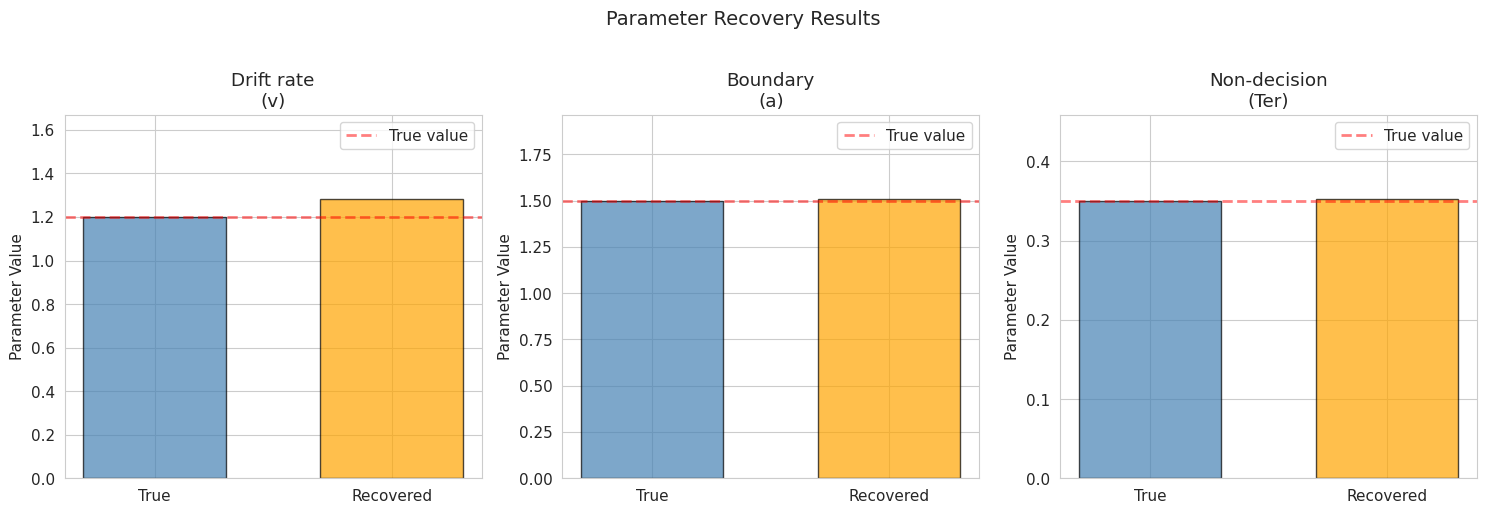


Interpretation:
- Bars should be similar height if recovery is good
- Orange bar (recovered) should be close to blue bar (true)
- Red dashed line shows the true value for reference


In [9]:
# Create comparison plot
# 1 row, 3 columns (one for each parameter)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Data for plotting
# Parameter names (with line breaks for better display)
params = ['Drift rate\n(v)', 'Boundary\n(a)', 'Non-decision\n(Ter)']

# True values
true_values = [true_v, true_a, true_ter]

# Recovered values
recovered_values = [recovered_v, recovered_a, recovered_ter]

# Plot each parameter
for i in range(3):
    # Create bar labels
    bar_labels = ['True', 'Recovered']
    
    # Create bar values
    bar_values = [true_values[i], recovered_values[i]]
    
    # Create bar colors
    bar_colors = ['steelblue', 'orange']
    
    # Create bar plot
    axes[i].bar(bar_labels, bar_values,
                color=bar_colors, 
                edgecolor='black', 
                alpha=0.7,
                width=0.6)
    
    # Add horizontal line at true value for reference
    axes[i].axhline(true_values[i], 
                    color='red', 
                    linestyle='--', 
                    alpha=0.5, 
                    linewidth=2, 
                    label='True value')
    
    # Add labels and title
    axes[i].set_ylabel('Parameter Value')
    axes[i].set_title(params[i])
    
    # Set y-axis limits
    max_value = max(true_values[i], recovered_values[i])
    axes[i].set_ylim(0, max_value * 1.3)
    
    # Add legend
    axes[i].legend()

# Add overall title
plt.suptitle('Parameter Recovery Results', fontsize=14, y=1.02)

# Adjust spacing
plt.tight_layout()

# Show plot
plt.show()

print("\nInterpretation:")
print("- Bars should be similar height if recovery is good")
print("- Orange bar (recovered) should be close to blue bar (true)")
print("- Red dashed line shows the true value for reference")

---
## Part 6: Fitting Real Data (Optional)

Now that we've validated our method works with synthetic data, we can apply it to real data!

### Loading Real Data

If you have real data, make sure it has:
- A column called 'rt' with response times (in seconds)
- A column called 'response' with choices (0 or 1)

Let's try to load some real data:

In [10]:
# Try to load real data
# Adjust the path below to point to your actual data file

print("Attempting to load real data...\n")

try:
    # Adjust this path to your data file
    data_path = '/home/student/Desktop/Groundeep/conferenza_DBNRT/Human_sim_40.xlsx'
    
    # Load the Excel file
    real_data = pd.read_excel(data_path)
    
    print("✓ Real data loaded successfully!")
    print(f"\nNumber of trials: {len(real_data)}")
    
    print("\nColumn names in the data:")
    column_list = real_data.columns.tolist()
    # Print first 10 columns
    for i in range(min(10, len(column_list))):
        print(f"  {i+1}. {column_list[i]}")
    
    if len(column_list) > 10:
        print(f"  ... and {len(column_list) - 10} more columns")
    
    print("\nFirst few rows:")
    print(real_data.head())
    
except FileNotFoundError:
    print("✗ Real data file not found.")
    print("We'll create example data instead.")
    
    # Generate example data that mimics real experiment
    real_data = synthetic_data.copy()
    print(f"\nUsing example data with {len(real_data)} trials")
    
except Exception as e:
    print(f"✗ Error loading data: {e}")
    print("We'll create example data instead.")
    
    # Generate example data
    real_data = synthetic_data.copy()
    print(f"\nUsing example data with {len(real_data)} trials")

Real data loaded successfully!
Number of trials: 12320

Column names in the data:
['ExperimentName', 'Subject', 'Session', 'Age', 'Clock.Information', 'Display.RefreshRate', 'Group', 'Name', 'RandomSeed', 'SessionDate', 'SessionTime', 'SessionTimeUtc', 'Block', 'ListPractice', 'ListPractice.Cycle', 'ListPractice.Sample', 'ListPractice2', 'ListPractice2.Cycle', 'ListPractice2.Sample', 'ListTest1', 'ListTest1.Cycle', 'ListTest1.Sample', 'ListTest2', 'ListTest2.Cycle', 'ListTest2.Sample', 'ListTest3', 'ListTest3.Cycle', 'ListTest3.Sample', 'Procedure[Block]', 'Running[Block]', 'Trial', 'CorrArrow', 'CorrMouse', 'ListStimPractice', 'ListStimPractice.Cycle', 'ListStimPractice.Sample', 'ListStimPractice2', 'ListStimPractice2.Cycle', 'ListStimPractice2.Sample', 'ListStimTest1', 'ListStimTest1.Cycle', 'ListStimTest1.Sample', 'ListStimTest2', 'ListStimTest2.Cycle', 'ListStimTest2.Sample', 'ListStimTest3', 'ListStimTest3.Cycle', 'ListStimTest3.Sample', 'n1', 'n2', 'Procedure[Trial]', 'Running[Tr

### Exploring the Real Data

In [11]:
# Make sure we have the right columns
# We need 'rt' (response time) and 'response' (choice: 0 or 1)

# Check if columns exist
has_rt = 'rt' in real_data.columns
has_response = 'response' in real_data.columns

if has_rt and has_response:
    
    print("="*60)
    print("DESCRIPTIVE STATISTICS")
    print("="*60)
    
    # Get RT data
    all_rts = real_data['rt']
    all_responses = real_data['response']
    
    # Calculate basic statistics
    n_trials = len(real_data)
    mean_rt = all_rts.mean()
    std_rt = all_rts.std()
    median_rt = all_rts.median()
    min_rt = all_rts.min()
    max_rt = all_rts.max()
    accuracy = all_responses.mean()
    
    # Print statistics
    print(f"\nNumber of trials: {n_trials}")
    print(f"Mean RT: {mean_rt:.3f}s (SD = {std_rt:.3f}s)")
    print(f"Median RT: {median_rt:.3f}s")
    print(f"RT range: [{min_rt:.3f}s, {max_rt:.3f}s]")
    print(f"\nAccuracy: {accuracy:.1%}")
    
    # Create visualizations
    # 2 rows, 2 columns of plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # ===== Plot 1: RT distribution =====
    print("\nCreating visualizations...")
    print("  1/4: Overall RT distribution")
    
    axes[0, 0].hist(all_rts, bins=50, edgecolor='black', 
                    alpha=0.7, color='steelblue')
    axes[0, 0].axvline(mean_rt, color='red', 
                       linestyle='--', linewidth=2, 
                       label=f"Mean = {mean_rt:.3f}s")
    axes[0, 0].set_xlabel('Response Time (seconds)')
    axes[0, 0].set_ylabel('Number of Trials')
    axes[0, 0].set_title('Distribution of Response Times')
    axes[0, 0].legend()
    
    # ===== Plot 2: RT by response type =====
    print("  2/4: RTs by response type")
    
    # Filter data for each response type
    rt_resp1 = real_data[real_data['response'] == 1]['rt']
    rt_resp0 = real_data[real_data['response'] == 0]['rt']
    
    # Count trials
    n_resp1 = len(rt_resp1)
    n_resp0 = len(rt_resp0)
    
    # Plot histograms
    axes[0, 1].hist(rt_resp1, bins=30, alpha=0.6, 
                    label=f'Response 1 (n={n_resp1})',
                    edgecolor='black', color='green')
    axes[0, 1].hist(rt_resp0, bins=30, alpha=0.6,
                    label=f'Response 0 (n={n_resp0})',
                    edgecolor='black', color='red')
    axes[0, 1].set_xlabel('Response Time (seconds)')
    axes[0, 1].set_ylabel('Number of Trials')
    axes[0, 1].set_title('RT by Response Type')
    axes[0, 1].legend()
    
    # ===== Plot 3: RT over time =====
    print("  3/4: RT over time (learning/fatigue)")
    
    # Create trial numbers
    trial_numbers = []
    for i in range(n_trials):
        trial_numbers.append(i)
    
    # Scatter plot of RTs
    axes[1, 0].scatter(trial_numbers, all_rts, alpha=0.3, s=10)
    
    # Add smoothed line (moving average)
    window = min(50, n_trials // 10)  # Window size
    if n_trials > window:
        # Calculate rolling mean manually
        rolling_mean = real_data['rt'].rolling(window=window, center=True).mean()
        axes[1, 0].plot(trial_numbers, rolling_mean, color='red', linewidth=2,
                       label=f'Moving average (n={window})')
    
    axes[1, 0].set_xlabel('Trial Number')
    axes[1, 0].set_ylabel('Response Time (seconds)')
    axes[1, 0].set_title('RT Across the Experiment')
    axes[1, 0].legend()
    
    # ===== Plot 4: Cumulative distribution =====
    print("  4/4: Cumulative distribution")
    
    # Sort RTs
    sorted_rt = np.sort(all_rts)
    
    # Calculate cumulative probability
    n_sorted = len(sorted_rt)
    cumulative = []
    for i in range(n_sorted):
        cum = (i + 1) / n_sorted
        cumulative.append(cum)
    
    cumulative = np.array(cumulative)
    
    # Plot
    axes[1, 1].plot(sorted_rt, cumulative, linewidth=2, color='steelblue')
    axes[1, 1].set_xlabel('Response Time (seconds)')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Distribution')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Show plots
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete!")
    
else:
    print("="*60)
    print("ERROR: Required columns not found")
    print("="*60)
    print("\nData doesn't have the required columns ('rt' and 'response')")
    print(f"\nAvailable columns ({len(real_data.columns)} total):")
    
    # Print first 20 columns
    column_list = real_data.columns.tolist()
    for i in range(min(20, len(column_list))):
        print(f"  {i+1}. {column_list[i]}")
    
    if len(column_list) > 20:
        print(f"  ... and {len(column_list) - 20} more")
    
    print("\nPlease rename or create columns named 'rt' and 'response'")
    print("Example:")
    print("  real_data['rt'] = real_data['YourRTColumn']")
    print("  real_data['response'] = real_data['YourResponseColumn']")

Data doesn't have the required columns ('rt' and 'response')
Available columns: ['ExperimentName', 'Subject', 'Session', 'Age', 'Clock.Information', 'Display.RefreshRate', 'Group', 'Name', 'RandomSeed', 'SessionDate', 'SessionTime', 'SessionTimeUtc', 'Block', 'ListPractice', 'ListPractice.Cycle', 'ListPractice.Sample', 'ListPractice2', 'ListPractice2.Cycle', 'ListPractice2.Sample', 'ListTest1', 'ListTest1.Cycle', 'ListTest1.Sample', 'ListTest2', 'ListTest2.Cycle', 'ListTest2.Sample', 'ListTest3', 'ListTest3.Cycle', 'ListTest3.Sample', 'Procedure[Block]', 'Running[Block]', 'Trial', 'CorrArrow', 'CorrMouse', 'ListStimPractice', 'ListStimPractice.Cycle', 'ListStimPractice.Sample', 'ListStimPractice2', 'ListStimPractice2.Cycle', 'ListStimPractice2.Sample', 'ListStimTest1', 'ListStimTest1.Cycle', 'ListStimTest1.Sample', 'ListStimTest2', 'ListStimTest2.Cycle', 'ListStimTest2.Sample', 'ListStimTest3', 'ListStimTest3.Cycle', 'ListStimTest3.Sample', 'n1', 'n2', 'Procedure[Trial]', 'Running[Tria

### Fitting the DDM to Real Data

In [12]:
# Check if we have the required columns
has_rt = 'rt' in real_data.columns
has_response = 'response' in real_data.columns

if has_rt and has_response:
    
    print("="*60)
    print("FITTING DDM TO REAL DATA")
    print("="*60)
    
    # Clean the data (remove extreme outliers)
    print("\nStep 1: Cleaning data...")
    
    # Calculate 99th percentile
    rt_99th = real_data['rt'].quantile(0.99)
    
    # Filter data
    # Keep only trials where:
    # - RT > 0.2 seconds (remove very fast responses)
    # - RT < 99th percentile (remove very slow responses)
    real_data_clean = real_data[
        (real_data['rt'] > 0.2) &
        (real_data['rt'] < rt_99th)
    ].copy()
    
    # Calculate how many trials were removed
    n_original = len(real_data)
    n_clean = len(real_data_clean)
    n_removed = n_original - n_clean
    
    print(f"  Original trials: {n_original}")
    print(f"  Clean trials: {n_clean}")
    print(f"  Removed: {n_removed} outliers")
    
    # Fit the model
    print("\nStep 2: Fitting DDM model...\n")
    real_fit_result = fit_ddm_model(real_data_clean)
    
    # Extract parameters
    fitted_v = abs(real_fit_result.x[0])
    fitted_a = real_fit_result.x[1]
    fitted_ter = real_fit_result.x[2]
    
    print("\n" + "="*60)
    print("ESTIMATED PARAMETERS")
    print("="*60)
    print(f"Drift rate (v):        {fitted_v:.3f}")
    print(f"Boundary (a):          {fitted_a:.3f}")
    print(f"Non-decision time:     {fitted_ter:.3f}s")
    print(f"\nNegative log-likelihood: {real_fit_result.fun:.2f}")
    print(f"Optimization successful: {real_fit_result.success}")
    
    # Model fit statistics
    n_params = 3  # We estimated 3 parameters
    n_obs = n_clean  # Number of observations
    nll = real_fit_result.fun  # Negative log-likelihood
    
    # Calculate AIC (Akaike Information Criterion)
    # AIC = 2*k + 2*NLL, where k is number of parameters
    aic = 2 * n_params + 2 * nll
    
    # Calculate BIC (Bayesian Information Criterion)
    # BIC = k*log(n) + 2*NLL, where n is number of observations
    bic = n_params * np.log(n_obs) + 2 * nll
    
    print(f"\nModel Fit Statistics:")
    print(f"  AIC: {aic:.2f}")
    print(f"  BIC: {bic:.2f}")
    print(f"  (Lower values indicate better fit)")
    
    # Interpretation
    print("\n" + "="*60)
    print("INTERPRETATION")
    print("="*60)
    
    print("\nDrift rate (v):")
    if fitted_v > 1.5:
        print("  → HIGH: Task was relatively easy, or excellent performance")
    elif fitted_v > 0.8:
        print("  → MODERATE: Normal performance")
    else:
        print("  → LOW: Difficult task, or below-average performance")
    
    print("\nBoundary separation (a):")
    if fitted_a > 1.5:
        print("  → HIGH: Conservative strategy (prioritizing accuracy)")
    elif fitted_a > 1.0:
        print("  → MODERATE: Balanced speed-accuracy trade-off")
    else:
        print("  → LOW: Aggressive strategy (prioritizing speed)")
    
    print("\nNon-decision time (Ter):")
    if fitted_ter > 0.4:
        print("  → HIGH: Slow perceptual or motor processes")
    elif fitted_ter > 0.25:
        print("  → NORMAL: Typical non-decision time")
    else:
        print("  → LOW: Fast perceptual and motor processes")
        
else:
    print("="*60)
    print("ERROR: Cannot fit model")
    print("="*60)
    print("\nRequired columns ('rt' and 'response') not found in data")
    print("Please prepare your data with these column names first.")

Cannot fit: required columns not found in data


---
## Summary and Conclusions

### What We Learned

1. **Accumulation models describe how we make decisions**
   - Evidence accumulates over time
   - We decide when we reach a threshold
   - This explains both choices AND response times

2. **The DDM has interpretable parameters**:
   - **v** (drift rate): How good is the evidence?
   - **a** (boundary): Speed vs accuracy preference
   - **w** (starting point): Initial bias
   - **Ter**: Non-decision processes

3. **Parameter recovery is essential**
   - We must validate our methods work
   - Generate data → Fit model → Check if we recover true parameters

4. **Real data can be complex**
   - Need to clean outliers
   - May need more sophisticated models
   - Always visualize your data first!

### Next Steps

To extend this analysis, you could:

1. **Allow parameters to vary by condition**
   - Does drift rate change with task difficulty?
   - Do people adjust boundaries when speed is emphasized?

2. **Include parameter variability**
   - Trial-to-trial variations in drift rate
   - Between-trial variations in starting point and non-decision time

3. **Hierarchical modeling**
   - Estimate group-level and individual parameters simultaneously
   - Use Bayesian methods (e.g., HDDM toolbox)

4. **Compare different models**
   - DDM vs LBA vs other accumulation models
   - Use model comparison methods (AIC, BIC, cross-validation)

### Key References

- **Ratcliff & McKoon (2008).** "The Diffusion Decision Model: Theory and Data for Two-Choice Decision Tasks." *Neural Computation*
- **Wagenmakers et al. (2007).** "An EZ-diffusion model for response time and accuracy." *Psychonomic Bulletin & Review*
- **Forstmann et al. (2016).** "Sequential Sampling Models in Cognitive Neuroscience: Advantages, Applications, and Extensions." *Annual Review of Psychology*

### Python Packages for DDM

- **HDDM**: Hierarchical Bayesian estimation of DDM parameters
- **PyDDM**: Flexible DDM simulation and fitting
- **PyBEAM**: Bayesian Evidence Accumulation Models

---

**Thank you for your attention!**

### Practice Exercise

Try this:
1. Generate new synthetic data with different parameters
2. Can you recover them?
3. What happens if you use fewer trials (e.g., 100 instead of 500)?
4. How does this affect parameter recovery accuracy?